In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from nilearn.glm.first_level import glover_hrf
from scipy.stats import zscore
from nilearn import datasets
from nilearn.plotting import (plot_anat, plot_epi, plot_roi,
                              plot_glass_brain, plot_stat_map,
                              plot_surf_stat_map, plot_img_on_surf)
from nilearn.image import mean_img, resample_img
from nilearn.surface import vol_to_surf
from nilearn.masking import apply_mask
import nibabel as nib


/usr/people/ye9829/.conda/envs/502b/lib/python3.9/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


/tmp/ipykernel_200689/4066665200.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stim_df.word[stim_df.word.isnull()] = stim_df.StimFile[stim_df.word.isnull()]


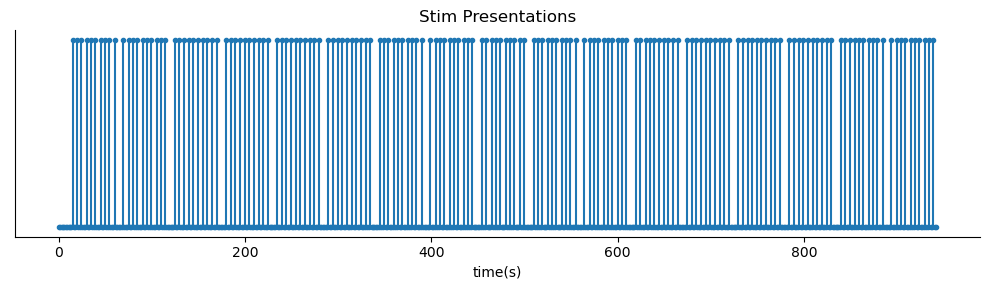

In [2]:
# load stimulus data
stim_df = pd.read_csv('/jukebox/PNI-classes/students/NEU502/2023-NEU502B/wlong/multilang/stimulus_record/780929_502b_project_code_edited_2023-04-05_13h44.30.136.csv')
t_scan_start = stim_df['key_resp.started'][0] + stim_df['key_resp.rt'][0]
stim_df.Language = stim_df.Language.str.split('_', expand=True).iloc[:, 0]  # isolating just the language name
stim_df.stimFile = stim_df.stimFile.str.split('/|_', expand=True).iloc[:, 1]
stim_df.StimFile = stim_df.StimFile.str.split('/|_', expand=True).iloc[:, 1]
stim_df['word'] = stim_df.stimFile
stim_df.word[stim_df.word.isnull()] = stim_df.StimFile[stim_df.word.isnull()]
stim_df = stim_df[~stim_df.word.isnull()].reset_index(drop=True)

tr = 1.5
n_trs = 630
time = np.arange(0, n_trs*tr, tr)
stim_trs, _ = np.histogram(stim_df['Sound.started']-t_scan_start, bins=time)  # stims binned into TRs (have not adjusted for if they are presented right at the end of a TR)

fig, ax = plt.subplots(figsize=(10, 3))
ax.stem(time[:-1], stim_trs, markerfmt='.', basefmt='C0')
ax.set_xlabel('time(s)')
ax.set_title('Stim Presentations')
ax.set_yticks([])
plt.tight_layout()
sns.despine()

In [3]:
# TODO: ask about block regressor / hrf because stims are of block_duration = 1 

In [4]:
# TODO: ask about confounds regressors - do we have any computed?

data shape: (78, 78, 54, 630)


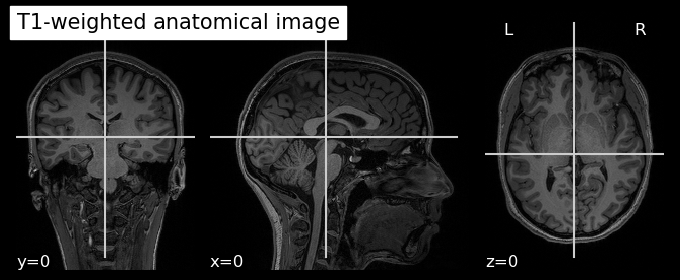

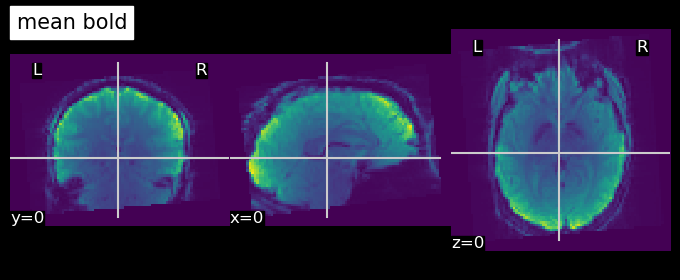

In [3]:
# load fmri data
data_path = '/jukebox/PNI-classes/students/NEU502/2023-NEU502B/wlong/multilang/data/bids/'
func_path = os.path.join(data_path, 'sub-002/ses-01/func/sub-002_ses-01_task-language_bold.nii.gz')
anat_path = os.path.join(data_path, 'sub-002/ses-01/anat/sub-002_ses-01_T1w.nii.gz')
cut_coords = (0, 0, 0)

# Plot the anatomical image
plot_anat(anat_path, cut_coords=cut_coords, title='T1-weighted anatomical image');


plot_epi(mean_img(func_path), cut_coords=cut_coords, cmap='viridis', title='mean bold');
func_data = nib.load(func_path).get_fdata()
n_trs = func_data.shape[3]
print('data shape:', func_data.shape)

(91, 109, 91)


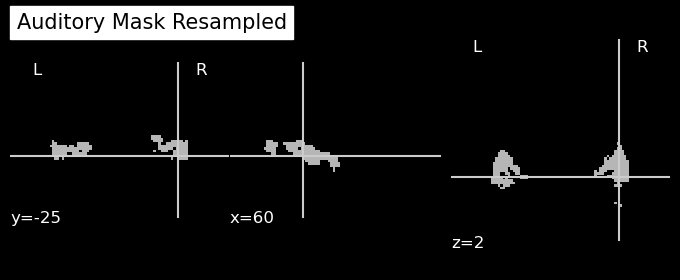

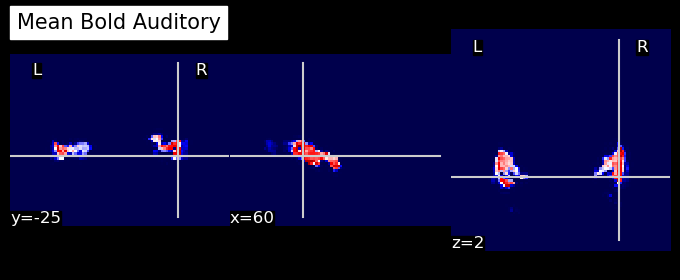

In [4]:
# get auditory mask
# source of auditory mask: https://github.com/ThomasYeoLab/CBIG/tree/master/stable_projects/brain_parcellation/Schaefer2018_LocalGlobal/Parcellations/MNI
# left hemisphere aud is 137-146 inclusive. right hem is 336-344. if you change the parcel file, you will need to go the the 
aud = np.hstack((np.arange(137, 147), np.arange(336, 345)))
masker_path = 'Schaefer2018_400Parcels_Kong2022_17Networks_order_FSLMNI152_2mm.nii.gz'
cut_coords = (60, -25, 2)
aud_masker = nib.load(masker_path)
aud_masker_data = aud_masker.get_fdata()
print(aud_masker_data.shape)
aud_masker_data = np.where(np.isin(aud_masker_data, aud), 1., 0)
aud_masker_img = nib.Nifti1Image(aud_masker_data, affine=aud_masker.affine)

# resample mask to match functional data
func_img = nib.load(func_path)
masker = resample_img(aud_masker_img, func_img.affine, target_shape=func_data.shape[:3], interpolation='nearest')
mask_aud = func_data.transpose(3, 0, 1, 2) * masker.get_fdata()  #using the apply mask function wasn't working at first
mask_aud = nib.Nifti1Image(mask_aud.transpose(1, 2, 3, 0), affine=func_img.affine)
plot_anat(masker, cut_coords=cut_coords, title='Auditory Mask Resampled');
plot_epi(mean_img(mask_aud), cut_coords=cut_coords, cmap='seismic', title='Mean Bold Auditory');

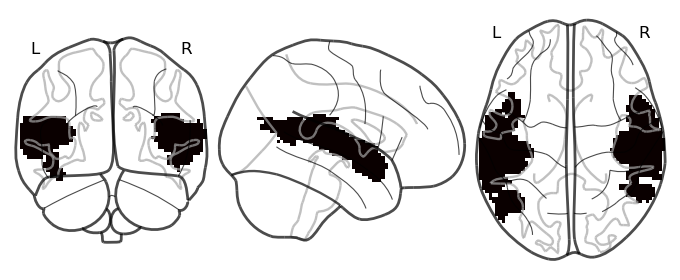

In [5]:
plot_glass_brain(masker);

In [6]:
# get n_times x n_voxels array of fmri signal within auditory cortex over time
bold_masked = func_data[masker.get_fdata().astype(bool)].T
print('masked data shape:', bold_masked.shape)

Y = zscore(bold_masked[:n_trs-1], axis=0)
X = np.vander(stim_trs, N=2, increasing=True)

masked data shape: (630, 2913)


In [7]:
# Run regression with basic OLS
b, _, _, _ = np.linalg.lstsq(X, Y, rcond=-1)
print('beta shape:', b.shape)

# Make beta coefficient brain map
beta_map = np.zeros(masker.shape)
mask_coords = np.where(masker.get_fdata() == 1)
beta_map[mask_coords] = b[0]

# Convert zero values to NaNs for plotting
beta_map[beta_map == 0] = np.nan

beta_img = nib.Nifti1Image(beta_map, affine=masker.affine)

beta shape: (2, 2913)


/usr/people/ye9829/.conda/envs/502b/lib/python3.9/site-packages/nilearn/_utils/niimg.py:63: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  warn(


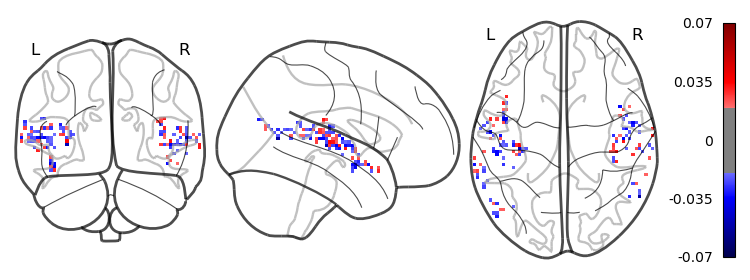

In [8]:
plot_glass_brain(beta_img, colorbar=True, cmap='seismic', threshold=0.02, 
                 plot_abs=False);

<AxesSubplot:>

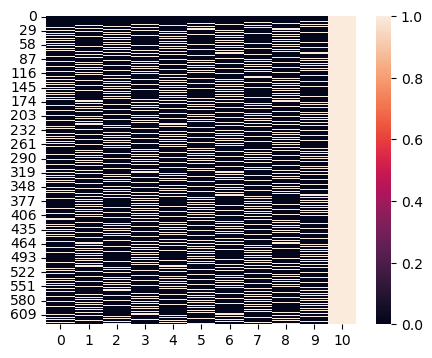

In [16]:
# time lagged regression
from scipy.linalg import hankel

filt_len = 10
padded_stim = np.pad(stim_trs, (filt_len-1, 0), constant_values=(0, 0))
X = hankel(padded_stim[:-filt_len+1], padded_stim[-filt_len:])
X = np.hstack((X, np.ones((X.shape[0], 1))))
fig, axs = plt.subplots(1, 1, figsize=(5, 4))
sns.heatmap(X, ax=axs)


beta shape: (11, 2913)


/usr/people/ye9829/.conda/envs/502b/lib/python3.9/site-packages/nilearn/_utils/niimg.py:63: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  warn(


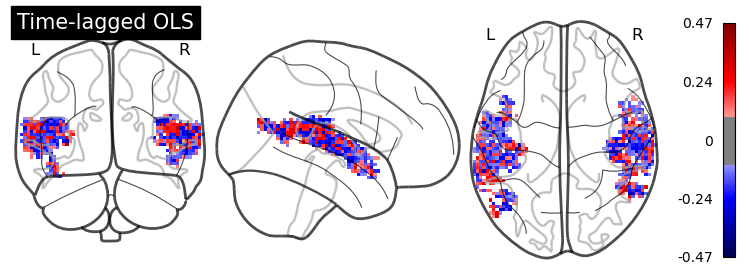

In [43]:
# Run regression with basic OLS
b, _, _, _ = np.linalg.lstsq(X, Y, rcond=-1)
print('beta shape:', b.shape)

# Make beta coefficient brain map
beta_map = np.zeros(masker.shape)
mask_coords = np.where(masker.get_fdata() == 1)
beta_map[mask_coords] = b[-2]

# Convert zero values to NaNs for plotting
beta_map[beta_map == 0] = np.nan

beta_img = nib.Nifti1Image(beta_map, affine=masker.affine)

plot_glass_brain(beta_img, colorbar=True, cmap='seismic', threshold=0.1, 
                 plot_abs=False, title='Time-lagged OLS');

### Questions

- block_duration = 1 with hrf?
- best way to translate between word presentation times and TRs when word durations are so short
- confound regressors?
- what is significant

### To-do

- compare languages instead of stim presentation vs rest
- refine stim to TR conversion
- do regression for all voxels as baseline comparison
- sub-005 analysis